Ваша задача – написать функцию haversine для подсчета расстояния между пунктами отправления и прибытия и, используя  pd.iterrows(), создать колонку distance с подсчитанным расстоянием. 

In [33]:
# Импортируем данные

import pandas as pd

path_to_file = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-sedelkin/analytics_practice/python/data/train.csv'
nyc = pd.read_csv(path_to_file)

In [65]:
# Напишем тестовую функцию

import numpy as np

def haversine(lat1, lat2, lon1, lon2, radius=6371) :
    haversine = 2 * radius * \
    np.arcsin(np.sqrt(pow(np.sin((np.radians(lat2) - np.radians(lat1)) / 2), 2) + \
                   np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * pow(np.sin((np.radians(lon2) - np.radians(lon1)) / 2), 2)))
    return haversine

Начнём тестировать быстродействие применения функции с наименее эффективного iterrows

In [35]:
%%timeit
dists = []
for index, row in nyc.iterrows():
    dists.append(haversine(row['pickup_latitude'], row['dropoff_latitude'], row['pickup_longitude'], row['dropoff_longitude']))
nyc['distance'] = dists

5.23 s ± 94.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
%%timeit 
nyc['distance'] = \
pd.Series(haversine(row.pickup_latitude, row.dropoff_latitude, row.pickup_longitude, row.dropoff_longitude) for index, row in nyc.iterrows())

5.99 s ± 103 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Проделаем ту же операцию, но используя itertuples вместо iterrows, и сравним срок выполнения. Стало существенно эффективнее!

In [68]:
%%timeit
dists = []
for row in nyc.itertuples():
    dists.append(haversine(row.pickup_latitude, row.dropoff_latitude, row.pickup_longitude, row.dropoff_longitude))
nyc['distance'] = dists

883 ms ± 49.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Повторим применение функции, используя метод pd.apply(), со встроенной pandas оптимизацией

In [57]:
%%timeit
nyc['distance'] = nyc.apply(lambda x: haversine(x['pickup_latitude'], x['dropoff_latitude'], x['pickup_longitude'], x['dropoff_longitude']), axis=1)

1.36 s ± 57.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [67]:
%%timeit
nyc['distance'] = nyc[['pickup_latitude', 'dropoff_latitude', 'pickup_longitude', 'dropoff_longitude']].apply(lambda row: haversine(row[0], row[1], row[2], row[3]), axis=1)

1.72 s ± 68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Достигнем максимальной быстроты, использовав векторизацию: подав функции на вход pandas.Series. Важно, что это будет работать не для всех функций, нужно чтобы все её этапы могли принимать серию в качестве переменной. 

In [66]:
%%timeit
nyc['distance'] = haversine(nyc.pickup_latitude, nyc.dropoff_latitude, nyc.pickup_longitude, nyc.dropoff_longitude)

8.96 ms ± 403 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [70]:
%%timeit
nyc['distance'] = haversine(nyc.pickup_latitude.values, nyc.dropoff_latitude.values, nyc.pickup_longitude.values, nyc.dropoff_longitude.values)

5.22 ms ± 373 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Вывод – эффективность методов в порядке убывания:

    1) векторизация NumPy array
    2) векторизация Series
    3) itertuples
    ––существенно хуже
    4) apply
    5) iterrows

In [78]:
nyc.loc[(nyc.dropoff_longitude == 0) | (nyc.dropoff_latitude == 0)].shape[0]

958

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


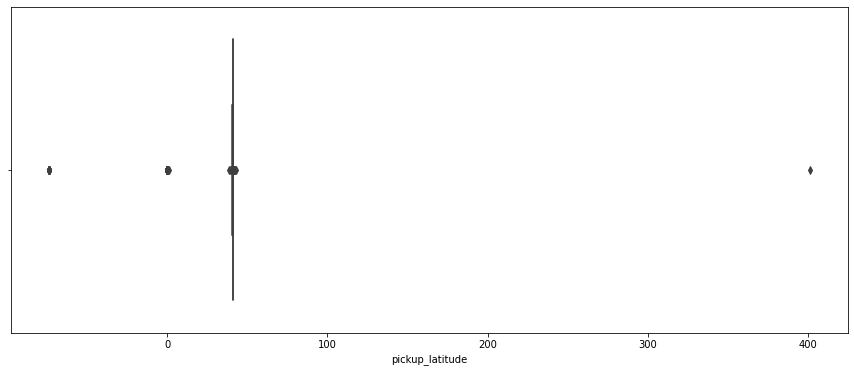

In [88]:
plt.figure(figsize=(15,6))
sns.boxplot(nyc.pickup_latitude)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


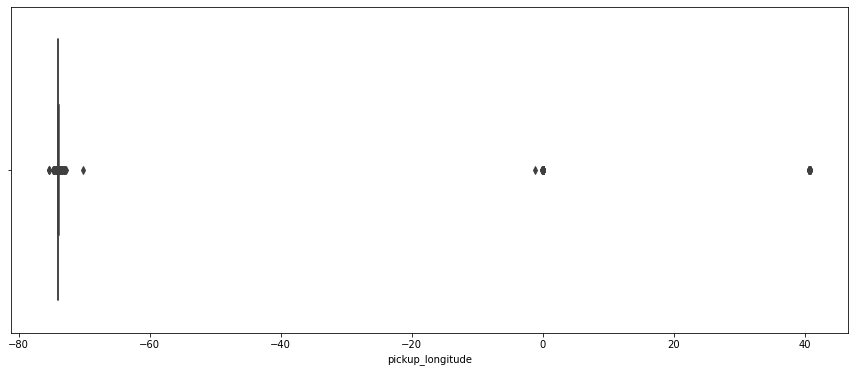

In [89]:
plt.figure(figsize=(15,6))
sns.boxplot(nyc.pickup_longitude)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


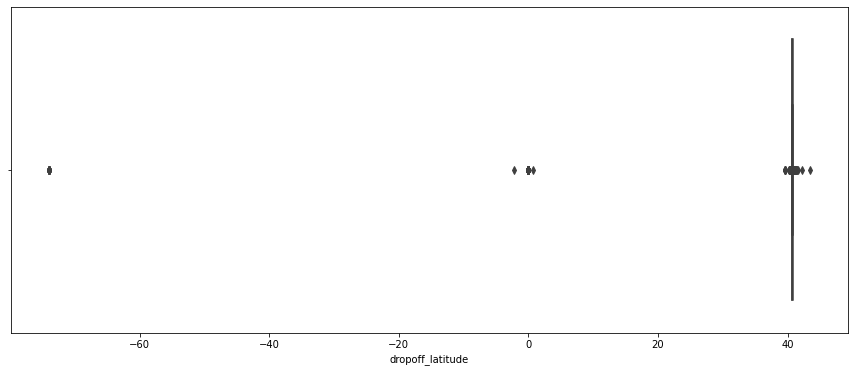

In [90]:
plt.figure(figsize=(15,6))
sns.boxplot(nyc.dropoff_latitude)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


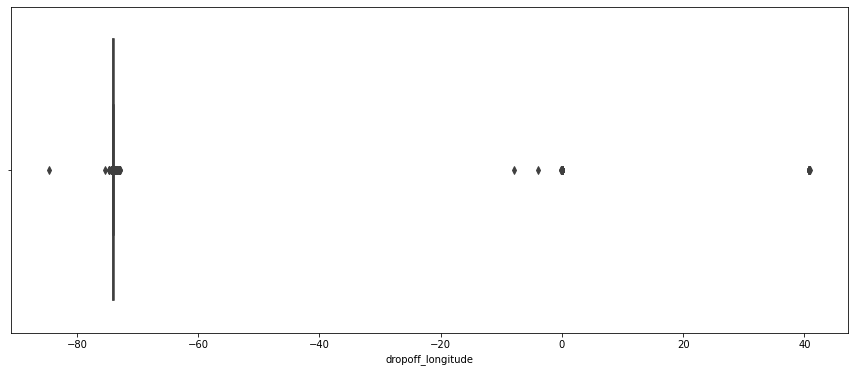

In [91]:
plt.figure(figsize=(15,6))
sns.boxplot(nyc.dropoff_longitude)

In [96]:
nyc_filtered = nyc.loc[(10 < nyc.pickup_latitude) & (nyc.pickup_latitude < 120) & (nyc.pickup_longitude < -60) & (10 < nyc.dropoff_latitude) & (nyc.dropoff_longitude < -60)]
nyc_filtered = nyc.loc[nyc.distance <= 50]
nyc_filtered.loc[nyc_filtered.distance.idxmax()].fare_amount

136.0